In [1]:
import os
import gc
import csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
use_gpu=True
import re

In [2]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d kazanova/sentiment140

 65% 53.0M/80.9M [00:00<00:00, 282MB/s]
100% 80.9M/80.9M [00:00<00:00, 286MB/s]


In [5]:
!kaggle kernels output stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm 

Output file downloaded to /content/Model Weights/checkpoint
Output file downloaded to /content/Model Weights/weights.data-00000-of-00001
Output file downloaded to /content/Model Weights/weights.index
Output file downloaded to /content/Sentiment-BiLSTM/saved_model.pb
Output file downloaded to /content/Sentiment-BiLSTM/variables/variables.data-00000-of-00001
Output file downloaded to /content/Sentiment-BiLSTM/variables/variables.index
Output file downloaded to /content/Tokenizer.pickle
Output file downloaded to /content/Word2Vec-twitter-100
Output file downloaded to /content/Word2Vec-twitter-100-trainable
Kernel log downloaded to /content/twitter-sentiment-analysis-using-word2vec-bilstm.log 


In [6]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [7]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

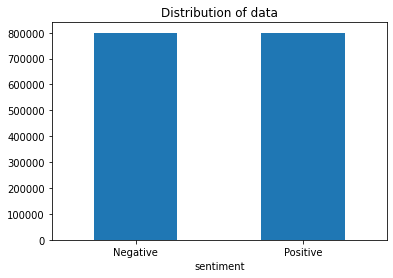

In [ ]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [9]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

In [10]:
def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)
    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [11]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 39 s, sys: 256 ms, total: 39.2 s
Wall time: 39.3 s


In [12]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  that s a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he can t update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it s not behaving at all  i m mad  why am i here  because i can t see you all over t

In [58]:
from sklearn.model_selection import train_test_split
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [14]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [16]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


In [17]:
import gensim.downloader as api
model = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [18]:
Embedding_dimensions = 100
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
  if token<60000:
    if model.wv.__contains__(word):
        embedding_matrix[token] = model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


Embedding Matrix Shape: (60000, 100)


In [19]:
list_tokens=[]
for i in range(60000):
  list_tokens.append(" ")
for word, token in tokenizer.word_index.items():
  if token<60000:
   if model.wv.__contains__(word):
     list_tokens[token]=word

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [20]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [21]:
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
list(swn.senti_synsets('slow'))
sentence='It was a really good day'
from nltk.tag import pos_tag
token = nltk.word_tokenize(sentence)
after_tagging = nltk.pos_tag(token)
print (token)
print (after_tagging)
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None
sentiment = 0.0
tokens_count = 0
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
['It', 'was', 'a', 'really', 'good', 'day']
[('It', 'PRP'), ('was', 'VBD'), ('a', 'DT'), ('really', 'RB'), ('good', 'JJ'), ('day', 'NN')]


In [22]:
def sentiment_value(after_tagging):
  sentiment_vector=[]
  for word, tag in after_tagging:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                sentiment_vector.append(1.0)
                continue
  
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                sentiment_vector.append(1.0)
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                sentiment_vector.append(1.0)
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment_vector.append(1+swn_synset.pos_score() + swn_synset.neg_score())
  return sentiment_vector

In [23]:
sentiments=[]
after_tagging = nltk.pos_tag(list_tokens)
sentiments.append(np.array(sentiment_value(after_tagging)))

In [24]:
sentiment_score = np.array(sentiments)

In [25]:
final_matrix=np.multiply(embedding_matrix,sentiment_score.T)

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding,Layer

In [27]:
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [28]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[final_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        attention(return_sequences=True),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        attention(return_sequences=True),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [29]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 attention (attention)       (None, 60, 200)           260       
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 attention_1 (attention)     (None, 60, 200)           260       
                                                                 
 conv1d (Conv1D)             (None, 56, 100)       

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
1336/1336 [==============================] - 403s 294ms/step - loss: 0.5083 - accuracy: 0.7327 - val_loss: 0.4232 - val_accuracy: 0.8036 - lr: 0.0010
Epoch 2/10
1336/1336 [==============================] - 387s 290ms/step - loss: 0.4299 - accuracy: 0.7996 - val_loss: 0.4011 - val_accuracy: 0.8168 - lr: 0.0010
Epoch 3/10
1336/1336 [==============================] - 389s 291ms/step - loss: 0.4148 - accuracy: 0.8087 - val_loss: 0.3982 - val_accuracy: 0.8194 - lr: 0.0010
Epoch 4/10
1336/1336 [==============================] - 390s 292ms/step - loss: 0.4056 - accuracy: 0.8135 - val_loss: 0.3929 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 5/10
1336/1336 [==============================] - 389s 291ms/step - loss: 0.3987 - accuracy: 0.8179 - val_loss: 0.3820 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 6/10
1336/1336 [==============================] - 390s 292ms/step - loss: 0.3933 - accuracy: 0.8208 - val_loss: 0.3761 - val_accuracy: 0.8306 - lr: 0.0010
Epoch 7/10
1336/1336 [============

In [30]:
#training_model.save_weights('drive/MyDrive/IR assignment/weight1.h5')
training_model.load_weights('drive/MyDrive/IR assignment/weight1.h5')

In [73]:
def get_sentiment(sentence):
  sentence=preprocess_apply(sentence)
  list_n=[]
  list_n.append(sentence)
  a=np.asarray(list_n)
  X = pad_sequences(tokenizer.texts_to_sequences(a), maxlen=input_length)
  return training_model.predict(X)[0][0]


In [ ]:
# import all methods and classes from the tkinter
from tkinter import *
 
# Function for clearing the  
# contents of all entry boxes
# And text area.
def clearAll() :
   
    # deleting the content from the entry box
    overallField.delete(0, END)
 
    # whole content of text area  is deleted
    textArea.delete(1.0, END)
     
# function to print sentiments
# of the sentence.
def detect_sentiment():
 
    # get a whole input content from text box
    sentence = textArea.get("1.0", "end")
 
    # Create a SentimentIntensityAnalyzer object.
    n=get_sentiment(sentence)
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    if n<=0.5:
      overallField.insert("Negative emotion",sentence)
    else:
      overallField.insert("Positive emotion",sentence)
 
 
# Driver Code
if __name__ == "__main__" :
    gui = Tk()
    gui.config(background =  "light green")
    gui.title("Sentiment Detector")
    gui.geometry("250x400")
    enterText = Label(gui, text = "Enter Your Sentence",
                                     bg = "light green")
    textArea = Text(gui, height = 5, width = 25, font = "lucida 13")
    check = Button(gui, text = "Check Sentiment", fg = "Black",
                         bg = "Red", command = detect_sentiment)
    overall = Label(gui, text = "sentence was rated as: ",
                                        bg = "light green")
 
    # create a text entry box 
    overallField = Entry(gui)
 
    clear = Button(gui, text = "Clear", fg = "Black",
                      bg = "Red", command = clearAll)
     
    Exit = Button(gui, text = "Exit", fg = "Black",
                        bg = "Red", command = exit)
 
    enterText.grid(row = 0, column = 2)
     
    textArea.grid(row = 1, column = 2, padx = 10, sticky = W)
     
    check.grid(row = 2, column = 2)
     
    overall.grid(row = 7, column = 2)
 
    overallField.grid(row = 8, column = 2)
     
     
    clear.grid(row = 11, column = 2)
     
    Exit.grid(row = 12, column = 2)
 
    # start the GUI
    gui.mainloop()